In [2]:
%pylab notebook

import rasterio.features
from shapely.geometry import Polygon, shape, mapping,MultiPolygon
# from shapely.ops import unary_union
# import geopandas as gp
import fiona
from fiona.crs import from_epsg
# import xarray as xr
import xarray
import glob
# import shapefile as shpf
import datacube
import datetime
import pandas as pd

import sys
import os.path
sys.path.append(os.path.expanduser('/g/data/u46/users/ext547/ewater/notebooks/dea-notebooks/other_notebooks/dea-notebooks/10_Scripts'))
import DEAPlotting
import DEADataHandling

# from shapely.geometry import asShape
# from shapely.geometry import MultiPolygon, Polygon

# import dask
# from distributed import Client, LocalCluster

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shape', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    data = rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)
    coords = [xarray.DataArray(data=coord.values, name=dim, dims=[dim], attrs={'units': coord.units}) 
              for dim, coord in geobox.coords.items()]
    return xarray.DataArray(data, coords=coords)

In [4]:
def get_shapes(shape_file):
    with fiona.open(shape_file) as shapes:
        crs = datacube.utils.geometry.CRS(shapes.crs_wkt)
        for shape in shapes:
            geom = datacube.utils.geometry.Geometry(shape['geometry'], crs=crs)
            yield geom, shape['properties']

In [5]:
#Percentage value for permanent water bodies. Everything water observation below this value will be filtered out
AtLeastThisWet  = 70

# Where are the  datacube-stats WOfS raster files located?
#wofsRasterFolder = '/g/data/u46/users/ext547/ewater/cambodia_cube/9_dea_stats/custom/lake_area/*/'
wofsRasterFolder = '/g/data/u46/users/ext547/ewater/cambodia_cube/9_dea_stats/custom/lake_area/projected/'

# The name and filepath of the final output polygon
#shape_file = '/g/data/u46/users/ext547/ewater/input_data/water_body/HydroLAKES_KHM_SHp/TonleSap_buffer_32648.shp'
shape_file = '/g/data/u46/users/ext547/ewater/input_data/water_body/HydroLAKES_KHM_SHp/TonleSap_buffer_102028.shp'
# The filepath of the final output polygon set
output_folder = '/g/data/u46/users/ext547/ewater/output_data/wofs/'

In [6]:
#Make a glob of all GeoTIFF files
alltiles  = glob.glob('{0}*.tif'.format(wofsRasterFolder))
# alltiles = alltiles[0:4]
alltiles

['/g/data/u46/users/ext547/ewater/cambodia_cube/9_dea_stats/custom/lake_area/projected/wofs_lake_20050101_projected.tif',
 '/g/data/u46/users/ext547/ewater/cambodia_cube/9_dea_stats/custom/lake_area/projected/wofs_lake_20030101_projected.tif',
 '/g/data/u46/users/ext547/ewater/cambodia_cube/9_dea_stats/custom/lake_area/projected/wofs_lake_20020101_projected.tif',
 '/g/data/u46/users/ext547/ewater/cambodia_cube/9_dea_stats/custom/lake_area/projected/wofs_lake_20110101_projected.tif',
 '/g/data/u46/users/ext547/ewater/cambodia_cube/9_dea_stats/custom/lake_area/projected/wofs_lake_20100101_projected.tif',
 '/g/data/u46/users/ext547/ewater/cambodia_cube/9_dea_stats/custom/lake_area/projected/wofs_lake_20010101_projected.tif',
 '/g/data/u46/users/ext547/ewater/cambodia_cube/9_dea_stats/custom/lake_area/projected/wofs_lake_20070101_projected.tif',
 '/g/data/u46/users/ext547/ewater/cambodia_cube/9_dea_stats/custom/lake_area/projected/wofs_lake_20060101_projected.tif',
 '/g/data/u46/users/ext5

In [8]:
hi_resolution

[30.0, 30.0]

In [7]:
#loop through WOfS GeoTIFF, keep 'permenant' water bodies and mask areas outside of shapefile.
wofslake = {}
yr_lst = []
area_lst = []

for wofsfile in alltiles: 
    # Save wofs year info from name
#     wofsyear = wofsfile[-12:-8]
    wofsyear = wofsfile[-22:-18]
    print(wofsyear)
    # Read in the data
    wofsRasterData = xarray.open_rasterio(wofsfile)
    # Filter our classified data layer to remove noise
    # Remove any pixels that are wet < 10% of the time
    wofsfiltered = wofsRasterData > AtLeastThisWet
    wofsfiltered = wofsfiltered.squeeze()
    # Change all zeros to NaN
    wofsfiltered = wofsfiltered.where(wofsfiltered !=0)
    shapes = get_shapes(shape_file)
#     crs = wofsRasterData.crs
    resolution = wofsRasterData.res
    upsample = 1
    hi_resolution = [r * upsample for r in resolution]
    for geometry, properties in shapes:
        geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry, hi_resolution, crs=geometry.crs, align=None)
        mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
#         print(mask.values)
        mask_num = mask *1 #bool to num
        mask_interp =  mask_num.interp_like(wofsfiltered, method='nearest')
        wofsArray = wofsfiltered.where(mask_interp == 1)  
#         wofsArray = wofsfiltered.where(mask)
        wofsArray['date'] = datetime.datetime(int(wofsyear),1,1) 
        wofslake[wofsyear] = wofsArray

        
    percentage_water = wofsArray.count().values/mask.sum().values
    wofs_area = wofsArray * (0.030 * 0.030)
    wofs_area = int(wofs_area.sum().values)
    yr_lst.append([wofsyear,percentage_water])
    area_lst.append([wofsyear,wofs_area])

    
cols = ['date','perc_wofs']
dates_df = pd.DataFrame(columns=cols,data=yr_lst)
dates_df = dates_df.sort_values(by=['date'])

cols = ['date','Permanent (>70% annually) water (km$^2$)']
area_df = pd.DataFrame(columns=cols,data=area_lst)
area_df = area_df.sort_values(by=['date'])
area_df.date = pd.to_datetime(area_df.date)
area_df= area_df.set_index('date')

2005


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


2003


KeyboardInterrupt: 

In [21]:
# mask_num = mask *1 #bool to num
# mask_interp =  mask_num.interp_like(wofsfiltered, method='nearest')
# wofsArray = wofsfiltered.where(mask_interp == 1)

In [22]:
wofs_clean = xarray.concat(wofslake.values(),'date')
wofs_clean = wofs_clean.to_dataset(dim='wofs')
wofs_clean = wofs_clean.sortby(wofs_clean.date)

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  from ipykernel import kernelapp as app


In [23]:
out_file = str(output_folder)+'annual_water.csv'
area_df.to_csv(out_file)

<IPython.core.display.Javascript object>


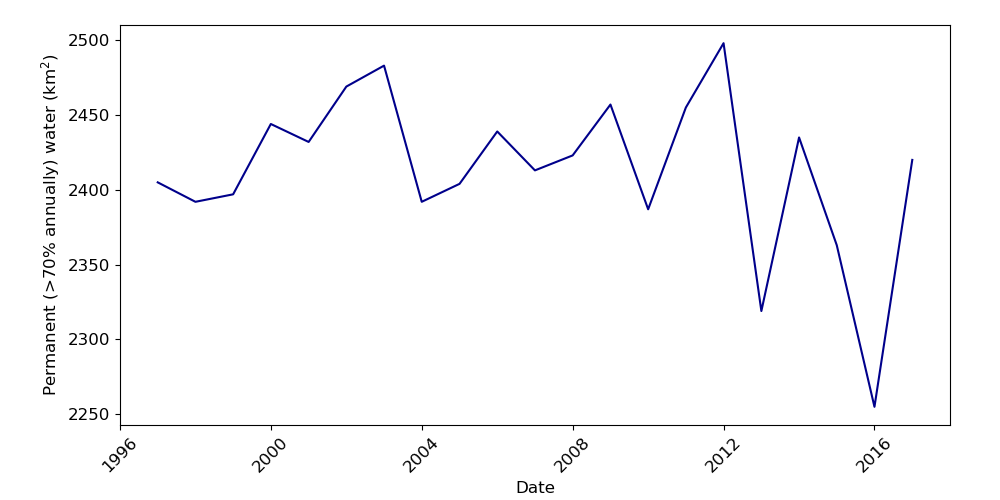

In [27]:
plt.figure(figsize=(10,5))
plt.plot(area_df.index,area_df['Permanent (>70% annually) water (km$^2$)'], 'darkblue')
plt.yticks(size=12)
plt.xticks(rotation=45,size=12) 
plt.xlabel('Date', size=12) #Set X label
plt.ylabel('Permanent (>70% annually) water (km$^2$)', size=12)
plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.15)

plt.savefig(str(output_folder)+'area_of_water.jpg')

In [17]:
# # out_file = str(output_folder)+'annual_time_series_line_97to17.gif'
# out_file = str(output_folder)+'annual_time_series_97to17.gif'

<IPython.core.display.Javascript object>


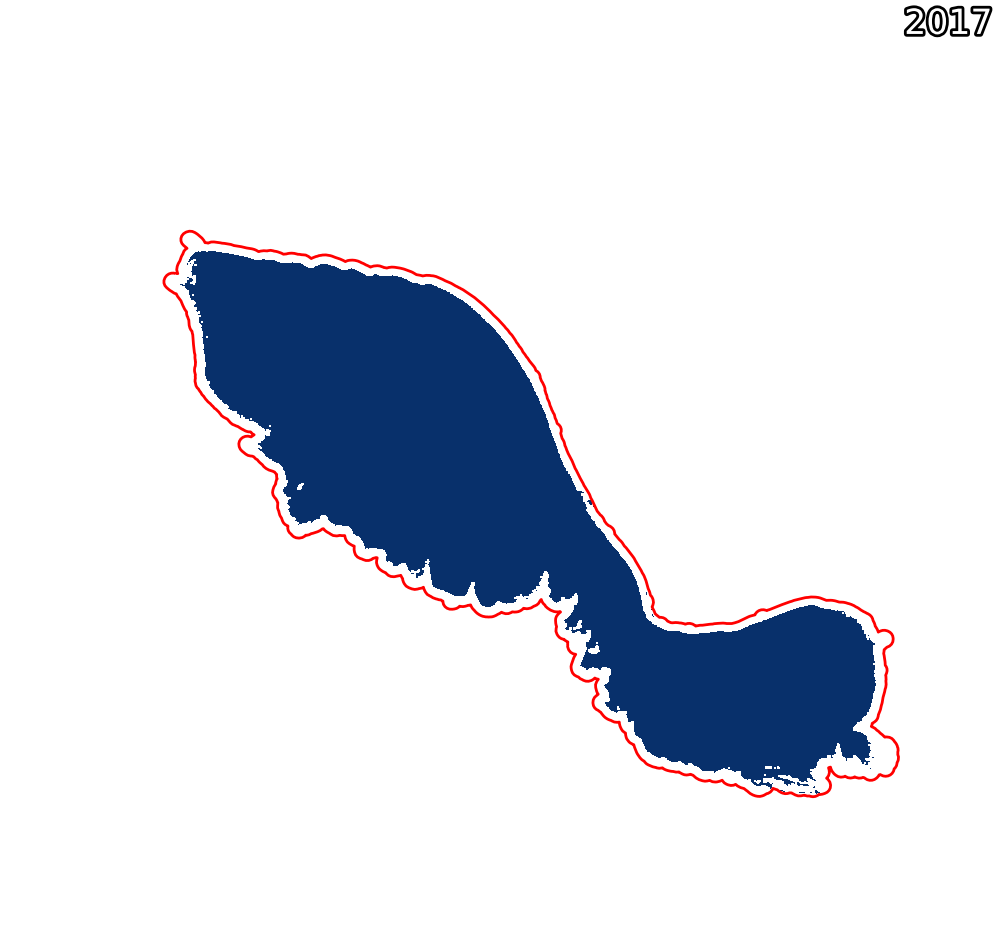

Generating 21 frame animation
    Exporting animation to /g/data/u46/users/ext547/ewater/output_data/wofs/annual_time_series_97to17.gif


In [25]:
out_file = str(output_folder)+'annual_time_series_97to17.gif'
DEAPlotting.animated_timeseries(ds = wofs_clean, output_path=out_file, bands = ['wofs'],
                                time_dim = 'date', x_dim = 'x',y_dim = 'y',
                                show_date= False, onebandplot_cbar=False,
                                title= wofs_clean.date.dt.year.values.tolist(),
                                shapefile_path = shape_file,shapefile_kwargs = {'linewidth':2,
                                                                                 'edgecolor':'red', 
                                                                                 'facecolor':"#00000000"},
                                onebandplot_kwargs={'cmap':'Blues','vmin':0, 'vmax':1}, 
                                interval=1000)

<IPython.core.display.Javascript object>


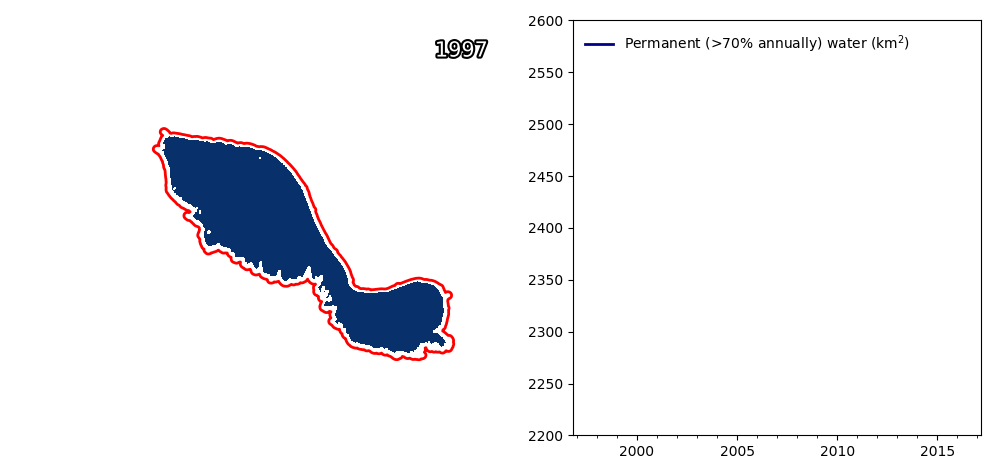

    Exporting animation to /g/data/u46/users/ext547/ewater/output_data/wofs/annual_time_series_line_97to17.gif


In [26]:
out_file = str(output_folder)+'annual_time_series_line_97to17.gif'

DEAPlotting.animated_timeseriesline(ds = wofs_clean, df = area_df,output_path=out_file, bands = ['wofs'],
                                time_dim = 'date', x_dim = 'x',y_dim = 'y',
                                show_date= False, onebandplot_cbar=False,
                                title= wofs_clean.date.dt.year.values.tolist(),
                                shapefile_path = shape_file,shapefile_kwargs = {'linewidth':2,
                                                                                 'edgecolor':'red', 
                                                                                 'facecolor':"#00000000"},
                                onebandplot_kwargs={'cmap':'Blues','vmin':0, 'vmax':1}, 
                                pandasplot_kwargs = {'linewidth':2,'ylim':[2200,2600],'style':'darkblue'},
                                interval=1000)

In [ ]:
help(DEAPlotting.animated_timeseries)

In [ ]:
a = (wofs_clean.isel(date=0).sum(dim=['x', 'y']).wofs.values 

In [ ]:
b = a* 0.0009

In [ ]:
geometry.area/b